## Basic Linear Regression


In this notebook, we work through code examples 4.37 onwards.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

az.style.use("arviz-darkgrid")


HOWELL1_DATA_LOCATION = '../../data/howell1.csv' 

In [2]:
df = pd.read_csv(HOWELL1_DATA_LOCATION)
df_adults = df[df['age'] >= 18]

In [3]:
df_adults.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


### Code 4.37

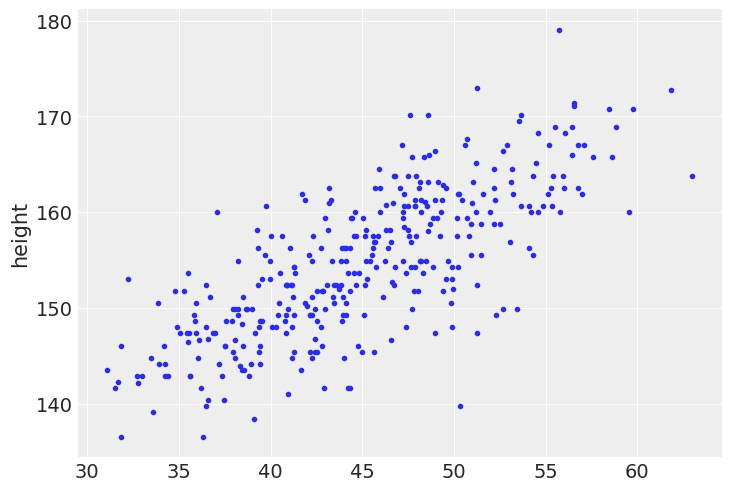

In [4]:
plt.plot(df_adults['weight'], df_adults['height'], '.')
plt.ylabel('height')

plt.show()

### The Model

The basic model that we dealt with in the last notebook was:
$$
\begin{align*}
    h_i & \overset{\text{iid}}{\sim} N(\mu, \sigma) \\
    \mu & \sim N(178, 20) \\
    \sigma & \sim \text{Uniform}(0, 50)
\end{align*}
$$

We now postulate that the mean height $\mu$ depends linearly on the predictor variable `weight`, which is denoted by $x$. The modified model can be written as:
$$
\begin{align*}
    h_i    & \overset{\text{iid}}{\sim} N(\mu_i, \sigma) \\
    \mu_i  & = \alpha + \beta (x_i - \bar{x}) \\
    \alpha & \sim N(178, 20) \\
    \beta  & \sim N(0, 10) \\
    \sigma & \sim \text{Uniform}(0, 50)
\end{align*}
$$

_From the book._

The mean $\mu$ is no longer a parameter to be estimated. Rather, as seen in the second line of the model, $\mu_i$ is constructed from other parameters, $\alpha$ and $\beta$, and the observed variable $x_i$. This line is not a stochastic relationship—there is no $\sim$ in it, but rather an $=$ in it—because the definition of $\mu_i$ is deterministic. That is to say that, once we know $\alpha$ and $\beta$ and $x_i$, we know $\mu_i$ with certainty.

### Prior Predictive Distribution

### Code 4.38 and 4.39

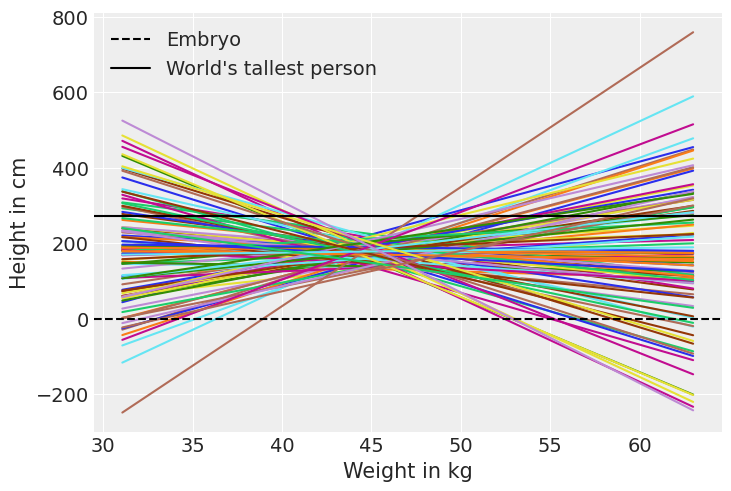

In [5]:
from scipy.stats import norm


N = 100 
a = norm.rvs(loc=178, scale=20, size=N)
b = norm.rvs(loc=0, scale=10, size=N)

x_bar = df_adults['weight'].mean()
x_min = df_adults['weight'].min()
x_max = df_adults['weight'].max()

wt_grid = np.linspace(x_min, x_max, 1000)

plt.xlabel('Weight in kg')
plt.ylabel('Height in cm')

for i in range(N):
    alpha_i = a[i]
    beta_i = b[i]
    
    mu_values = [alpha_i + beta_i * (x - x_bar) for x in wt_grid]
    
    plt.plot(wt_grid, mu_values)

plt.axhline(y=0, linestyle='--', color='black', label="Embryo")
plt.axhline(y=272, linestyle='-', color='black', label="World's tallest person")

plt.legend()

plt.show()

### $\beta$ as a Log-Normal Random Variable

Since we know that height is typically positively correlated with weight, we model $\beta$ as a log-normal variable instead of a normally distributed variable. A random variable $Y$ is log-normally distributed if the logarithm of $Y$ is normally distributed. Therefore let $Z = \log Y$ and assume that $Z \sim N(0, s)$, We wish to find out the distribution of $Y = e^{Z}$. Let $F_Y$ be the cdf of $Y$. 
$$
\begin{align*}
    F_Y(y) & = \text{Pr}\{ Y \leq y\} \\
           & = \text{Pr}\{ e^{Z} \leq y \} \\
           & = \text{Pr}\{ Z \leq \log y \} \\
           & = \int_{- \infty}^{\log y} \frac{1}{\sqrt{2 \pi} s} \cdot \exp \left \{ - \frac{x^2}{2s} \right \} dx
\end{align*}
$$

The pdf $f_Y$ of $Y$ is given by $\frac{d F_Y(y)}{dy}$. In order to evaluate the differential under the integral sign, we use Leibnitz's Theorem which states:
$$
    \frac{d}{dx} \int_{a(x)}^{b(x)} f(x, t) dt = f(x, b(x)) \frac{d b(x)}{dx} - f(x, a(x)) \frac{d a(x)}{d x} 
            + \int_{a(x)}^{b(x)} \frac{\partial f(x, t)}{\partial x} d t.
$$
to obtain:
$$
    f_Y(y) = \frac{1}{\sqrt{2 \pi}} \cdot \frac{1}{s y} \cdot \exp \left \{ - \frac{(\log y)^2}{2 s^2}\right \} \quad (0 < y < \infty).
$$

### Code 4.40

<AxesSubplot:ylabel='Density'>

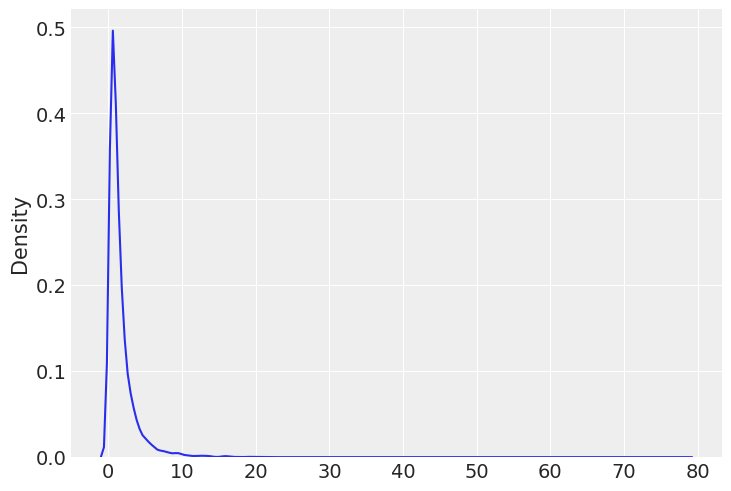

In [6]:
from scipy.stats import lognorm


beta_vals = lognorm.rvs(s=1, size=10000)
sns.kdeplot(beta_vals)

### Prior Predictive Simulation with Log-Normal Prior

### Code 4.41

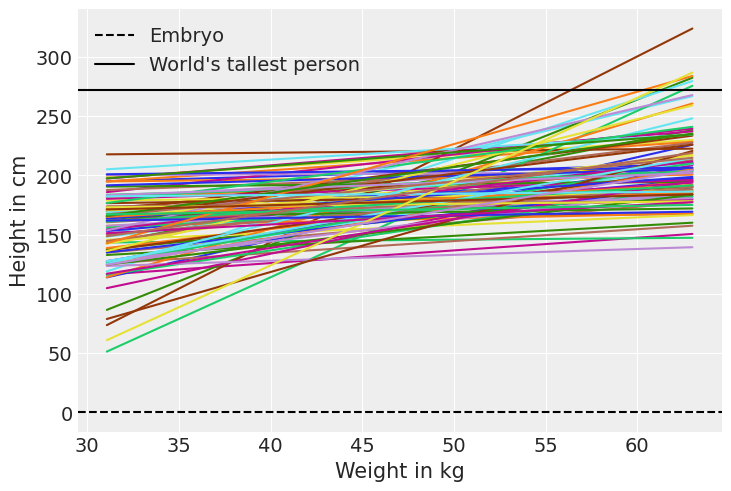

In [7]:
N = 100 
a = norm.rvs(loc=178, scale=20, size=N)
b = lognorm.rvs(s=1, size=N)

x_bar = df_adults['weight'].mean()
x_min = df_adults['weight'].min()
x_max = df_adults['weight'].max()

wt_grid = np.linspace(x_min, x_max, 1000)

plt.xlabel('Weight in kg')
plt.ylabel('Height in cm')

for i in range(N):
    alpha_i = a[i]
    beta_i = b[i]
    
    mu_values = [alpha_i + beta_i * (x - x_bar) for x in wt_grid]
    
    plt.plot(wt_grid, mu_values)

plt.axhline(y=0, linestyle='--', color='black', label="Embryo")
plt.axhline(y=272, linestyle='-', color='black', label="World's tallest person")

plt.legend()

plt.show()

### Finding the Posterior Distribution

$$
\begin{align*}
    h_i    & \overset{\text{iid}}{\sim} N(\mu_i, \sigma) \\
    \mu_i  & = \alpha + \beta (x_i - \bar{x}) \\
    \alpha & \sim N(178, 20) \\
    \beta  & \sim \text{Lognormal}(0, 1) \\
    \sigma & \sim \text{Uniform}(0, 50)
\end{align*}
$$

### Code 4.42

In [8]:
with pm.Model() as m_4_3:
    alpha = pm.Normal('alpha', mu=178, sigma=20)
    beta = pm.Lognormal('beta', mu=0, sigma=1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    
    x_bar = df_adults['weight'].mean()
    mu = alpha + beta * (df_adults['weight'] - x_bar)
    
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=df_adults['height'])
    
    trace_4_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

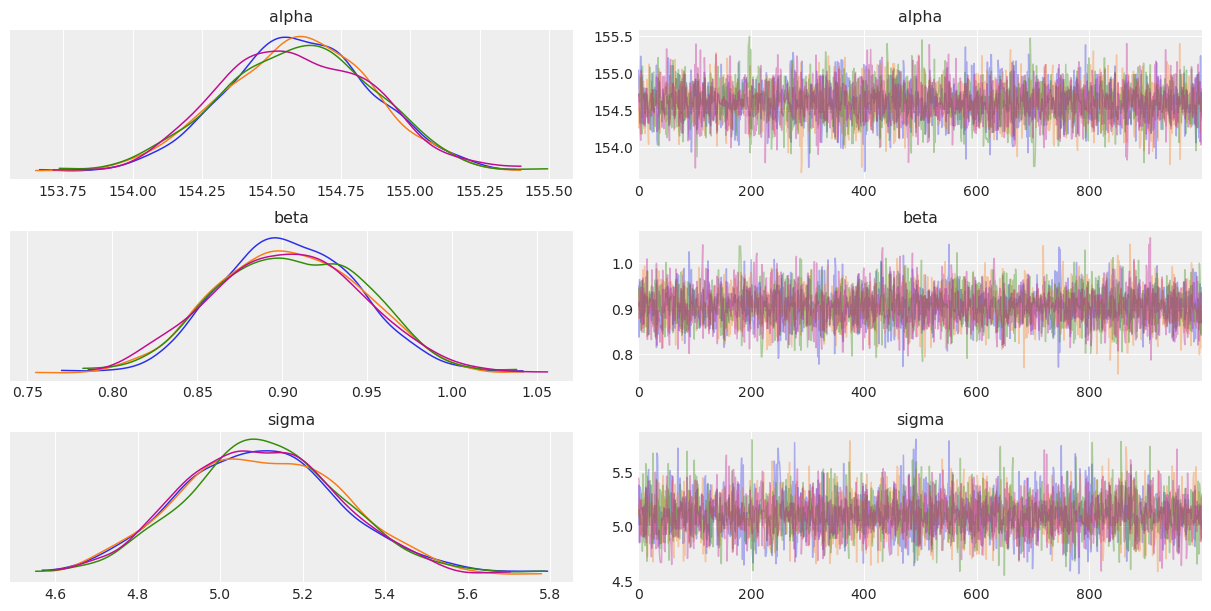

In [9]:
az.plot_trace(trace_4_3)

### Code 4.44

In [10]:
az.summary(trace_4_3, hdi_prob=0.89)

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,154.596,0.273,154.164,155.026,0.004,0.003,5412.0,5412.0,5458.0,2420.0,1.0
beta,0.905,0.043,0.840,0.974,0.001,0.000,5326.0,5270.0,5363.0,3247.0,1.0
sigma,5.102,0.195,4.789,5.407,0.003,0.002,4884.0,4852.0,4908.0,2832.0,1.0


### Code 4.45

In [11]:
trace_df = pm.trace_to_dataframe(trace_4_3)

trace_df.cov().round(3)

,alpha,beta,sigma
alpha,0.075,-0.000,-0.001
beta,-0.000,0.002,0.000
sigma,-0.001,0.000,0.038


### Code 4.46

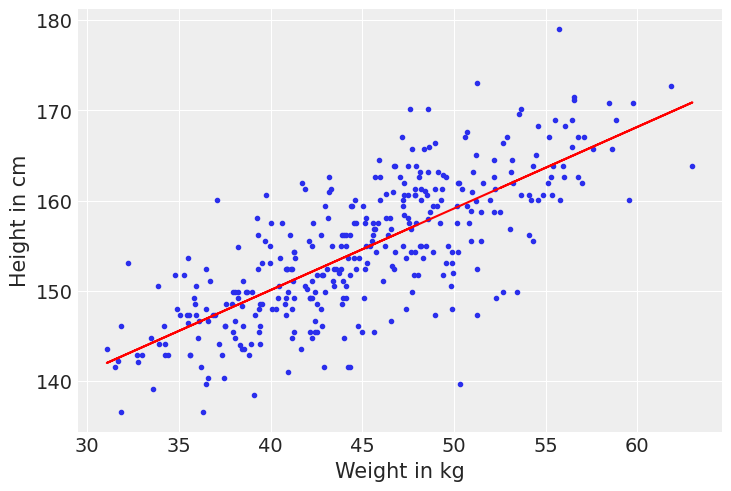

In [12]:
alpha_mean = trace_df['alpha'].mean()
beta_mean = trace_df['beta'].mean()
x_bar = df_adults['weight'].mean()

post_line = alpha_mean + beta_mean * (df_adults['weight'] - x_bar)

plt.plot(df_adults['weight'], df_adults['height'], '.')
plt.plot(df_adults['weight'], post_line, 'r-')

plt.xlabel('Weight in kg')
plt.ylabel('Height in cm')

plt.show()

### Modeling the Scattering Around the Mean Line 

In [13]:
trace_df.sample(2)

,alpha,beta,sigma
3463,154.107971,0.807435,5.051413
2230,154.575165,0.897780,5.005672


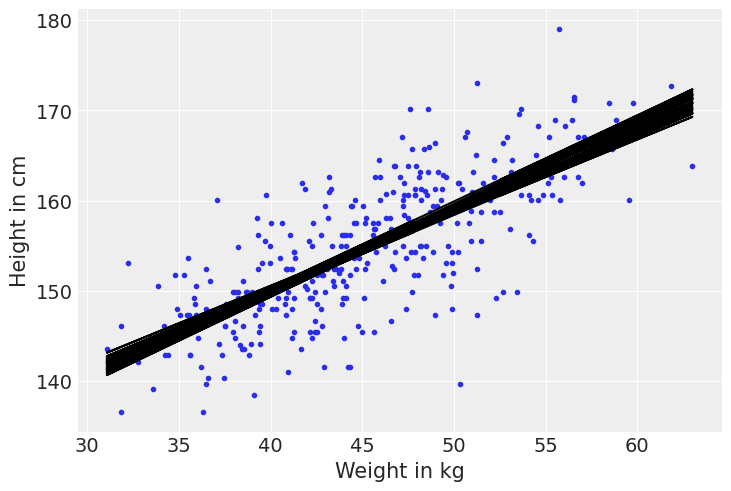

In [14]:
sample = trace_df.sample(30)
x_bar = df_adults['weight'].mean()

plt.plot(df_adults['weight'], df_adults['height'], '.')

plt.xlabel('Weight in kg')
plt.ylabel('Height in cm')

for idx, row in sample.iterrows():
    post_line = row['alpha'] + row['beta'] * (df_adults['weight'] - x_bar)    
    plt.plot(df_adults['weight'], post_line, '-', color='black')

plt.show()